In [1]:
cd(joinpath(homedir(),"Projects/ASTRAL/soundings/src/"))

# activate the environment
# an environment is just a path with Manifest.toml and Project.toml
using Pkg; Pkg.activate("..")
Pkg.instantiate()

using Revise
# using RegularExpressions # Regexs natively loaded in julia
using CSV, DataFrames
using Statistics
using Interpolations
using Dates
using PyPlot

  Activating project at `~/Projects/ASTRAL/soundings`


In [2]:
# thermodynamics of moist air functions

# constants
Cp = 1005.7  # from my Davies-Jones function, was 1005.
Cpv = 1870.0 # J/kg/K
Cw  = 4190.0
L0 = 2.501e6 # J/kg

C = 273.15 # K

Rd = 287.04
Rv = 461.5
RdoRv=Rd/Rv

"latent heat of water vapor"
LvK(TempK) = 2.501e6 + (Cpv-Cw) * (TempK-273.0)

"""
es(T,p) = is saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [Pa] (note the reversed input order), es [Pa]
Calling with optional keywords changes the units and
ignores the positional arguments.
es(T,p; TK=tk[Kelvin], P=pr[hPa])
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function es(T, p=1e5)
    # P in hPa
    P=p*1e-2
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # es in Pa
end

"es in hPa, same as keyword P[hPa]"
function es(T; P)
    # P in hPa
    esat =       6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # es in hPa, same as P
end

# # supply TK [Kelvin] by keyword, ignores positional T!!
# function es(T,p=1e5; TK=T+C, P=p*1e-2)
#     # P in hPa
#     T = TK - C
#     esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # convert es to Pa
# end

"""
qs(p,T) is saturation specific humidity based on Wexler's formula for es
with enhancement factor (see es.m).
p [Pa], T [degrees C], qs [kg/kg]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function qs(p,T)
    esat = es(T,p) # T[C], p[Pa] method
    qsat = RdoRv*esat / (p + (RdoRv-1)*esat)
end

"dqsdT(p,T[C]) derivative of qs with respect to T at p,T by autodiff of Bolton's qs"
dqsdT(p,T) = ForwardDiff.derivative(t -> qs(p,t), T)

# wet bulb temperature methods
# for approximating the evap process

"General single Newton iteration to update x toward f(x) = fhat for a univariate function f"
updatex(f, x, fhat) = x + (fhat-f(x)) / ForwardDiff.derivative(f, x)

"""
Twet_autodiff(T[K], q[kg/kg], p[Pa]; niter=2) wet bulb temperature using Newton's method
for target specific humidity q[kg/kg]. Uses automatic differntiation.
"""
function Twet_autodiff(T, q, p; niter=2)
    f(t) = (t - T) + LvK((T+t)/2)/Cp * (qs(p,t-C) - q)
    t=T
    for i in 1:niter
        t = updatex(f, t, 0)
    end
    t
end
# 2 iterations converges to ~0.001 K

# call as...
# q = rh*qs(pa, Ta)
# Twet_autodiff(Ta, rh*qs(pa, Ta-C), pa)


# thermo functions

"Exner function = T/θ = (p/p0)^(Rd/Cp)"
Exner(p; p0=1000.0) = (p/p0)^0.287
Exner(p, qv; p0=1000.0) = (p/p0) ^ ((Rd/Cp) * (1 - 0.28*qv))

"potential temperature [K] = theta(T[K], p[hPa])"
theta(T, p) = T/Exner(p)
theta(T, p, qv) = T/Exner(p, qv)

"vapor pressure ev(p,qv); ev has units of p"
ev(p, qv) = p*qv / (RdoRv + qv)

"T[K] LCL from Bolton, Temp[K], ev[hPa]"
Tlcl(Temp, ev) = 2840/(3.5*log(Temp) - log(ev) - 4.805) + 55;
Tlcl(Temp, p, qv) = Tlcl(Temp, ev(p,qv))

"equivalent potential temperature"
function theta_equiv(T::Real, p::Real, qv::Real)
    Tl = Tlcl(T, p, qv)
    thetae = theta(T,p,qv) * exp((3376.0/Tl - 2.54) * qv * (1 + 0.81*qv))
end

# qs(1e2*1000, 290.0-C)
"equivalent saturated potential temperature theta_equiv_sat(T[K], p[hPa])"
theta_equiv_sat(T, p) = theta_equiv( T, p, qs(1e2*p, T-C) )

theta_equiv_sat

In [8]:
gethostname()

"myrk"

In [9]:
# data RAOBE files
if gethostname() |> startswith("squall")
    datapath = "/Users/sdeszoek/Library/CloudStorage/OneDrive-SharedLibraries-UW/og_ekamsat-st - Documents/RR2306/RR2306_Science_Share/Radiosondes/Revelle"
elseif gethostname() |> startswith("fog")
    datapath = joinpath(homedir(),"Projects/ASTRAL/soundings/data/Revelle")
    # datapath = "/Users/sdeszoek/Library/CloudStorage/OneDrive-SharedLibraries-OregonStateUniversity/og_ekamsat-st - Documents/RR2306/RR2306_Science_Share/Radiosondes"
elseif gethostname() |> startswith("sundog")
    datapath = joinpath(homedir(),"Projects/ASTRAL/soundings/data/Revelle")
elseif gethostname() |> startswith("myrk")
    datapath = joinpath(homedir(),"Projects/ASTRAL/soundings/data/Revelle")
else
    datapath = joinpath(homedir(),"Projects/ASTRAL/soundings/data/Revelle")
end

raobe_file(dt) = joinpath(datapath, "RAOBE" * Dates.format(dt, "yyyymmddHH") * ".csv")
raobe_file(DateTime(2023,6,17,0,0,0))

raobe_files = filter(startswith("RAOBE"), readdir(datapath))
# xtrct_datestamp(f) = f[6:15]  # brittle
xtrct_datestamp(f) = match(r"RAOBE([0-9]{10})\.csv", f)[1]

raobe_dt(f) = DateTime(xtrct_datestamp(f), "yyyymmddHH")

raobe_dt (generic function with 1 method)

In [10]:
"single-character replacer can handle tabs and \u00b0 degree character °"
stripjunk(f) = f # IOBuffer(replace(read(f), UInt8('\t') => UInt8(' '), UInt16('\u00b0') => UInt8('d')) )

"change sign, e.g. for lat,lon. false->-1, true->1"
signer(bool) = 2(0+bool)-1

"read the file and return (DataFrame, lat, lon)"
function read_raobe( file )
    open( file, "r" ) do io
        lat = 0
        lon = 0
        # read header lines and parse lat,lon
        ln = readline( io )
        while match(r"RAOB/DATA", ln) === nothing
            if startswith(ln, "LAT")
                mtc = match(r"LAT,([\d.]*),([NS])", ln)
                lat += parse(Float32, mtc[1]) * signer(mtc[2]=="N")
                # show("lat=$(lat)")
            elseif startswith(ln, "LON")
                mtc = match(r"LON,([\d.]*),([EW])", ln)
                lon += parse(Float32, mtc[1]) * signer(mtc[2]=="E")
            end
            ln = readline( io )
        end
        # "PRES,TEMP,RH,WIND,SPEED,GPM"
        CSV.read( stripjunk( io ),
            DataFrame, delim=",", stripwhitespace=true, ignorerepeated=true ), lat, lon
    end
end

# test: read 1 sounding
df, lat, lon =  read_raobe(joinpath(datapath, raobe_files[1]))

(2154×6 DataFrame
  Row │ PRES     TEMP     RH     WIND   SPEED    GPM   
      │ Float64  Float64  Int64  Int64  Float64  Int64 
──────┼────────────────────────────────────────────────
    1 │  1008.4     23.7     43    357      8.7     20
    2 │  1007.3     27.0     47    264      6.2     30
    3 │  1006.2     28.8     52    238     11.1     40
    4 │  1005.0     28.6     61    238     11.4     50
    5 │  1003.9     28.5     71    239     11.5     60
    6 │  1002.8     28.5     76    239     11.5     70
    7 │  1001.6     28.3     76    239     11.5     80
    8 │  1000.5     28.2     76    239     11.7     90
    9 │   999.4     28.2     76    238     11.8    100
   10 │   998.3     28.1     77    238     11.7    110
   11 │   997.2     28.0     77    238     11.7    120
  ⋮   │    ⋮        ⋮       ⋮      ⋮       ⋮       ⋮
 2145 │    44.5    -61.3      2    121      6.1  21460
 2146 │    44.4    -61.0      3    123      5.8  21470
 2147 │    44.3    -60.8      4    125      5.

In [11]:
# load and concatenate many raw uninterpolated soundings

"load and concatenate many soundings"
function cat_raobe( files, datapath=datapath )
    nt = length( files )
    nz = 3000 # some big enough number

    dtime = raobe_dt.(files)
    lat = zeros(nt)
    lon = zeros(nt)

    # initialize DataFrame variables as NaN arrays
    vars = ["pres","temp","rh","wind","speed","gpm"]
    nv = length(vars)

    pres = NaN.+zeros(nz,nt)
    temp = NaN.+zeros(nz,nt)
    rh = NaN.+zeros(nz,nt)
    wind = NaN.+zeros(nz,nt)
    speed = NaN.+zeros(nz,nt)
    gpm = NaN.+zeros(nz,nt)
    # following doesn't init outside the loop scope...
    # for var in vars
    #     eval("$(var) = NaN.+zeros(nz,nt)]")
    # end

    i = 0
    for f in files
        i += 1
        dtime[i] = raobe_dt(f)
        df,lat[i],lon[i] = read_raobe(joinpath(datapath, f))
        nzi = nrow(df)
        pres[1:nzi,i] .= df[!,:PRES]
        temp[1:nzi,i] .= df[!,:TEMP]
        rh[1:nzi,i] .= df[!,:RH]
        wind[1:nzi,i] .= df[!,:WIND]
        speed[1:nzi,i] .= df[!,:SPEED]
        gpm[1:nzi,i] .= df[!,:GPM]
        # for var in vars
        #     nzi = length(df[!,:PRES])
        #     eval("$(var)[1:nzi,i] .= df[!,:$(uppercase(var))]")
        # end
    end
    lat,lon,dtime, pres,temp,rh,wind,speed,gpm
end

dtime = raobe_dt.(raobe_files)

36-element Vector{DateTime}:
 2023-06-17T00:00:00
 2023-06-17T06:00:00
 2023-06-17T12:00:00
 2023-06-17T18:00:00
 2023-06-18T00:00:00
 2023-06-18T18:00:00
 2023-06-19T00:00:00
 2023-06-19T06:00:00
 2023-06-19T12:00:00
 2023-06-19T18:00:00
 2023-06-20T00:00:00
 2023-06-20T06:00:00
 2023-06-20T12:00:00
 ⋮
 2023-06-22T12:00:00
 2023-06-22T15:00:00
 2023-06-22T18:00:00
 2023-06-22T21:00:00
 2023-06-23T00:00:00
 2023-06-23T06:00:00
 2023-06-23T12:00:00
 2023-06-23T15:00:00
 2023-06-23T18:00:00
 2023-06-23T21:00:00
 2023-06-24T00:00:00
 2023-06-24T06:00:00

In [12]:
# metacode some assignments 
vars = ["pres","temp","rh","wind","speed","gpm"]
nzi = nrow(df)
for var in vars
    print("$(var)[1:nzi,i] .= df[!,:$(uppercase(var))]\n")
end

pres[1:nzi,i] .= df[!,:PRES]
temp[1:nzi,i] .= df[!,:TEMP]
rh[1:nzi,i] .= df[!,:RH]
wind[1:nzi,i] .= df[!,:WIND]
speed[1:nzi,i] .= df[!,:SPEED]
gpm[1:nzi,i] .= df[!,:GPM]


In [13]:
# read the data in all RAOBE files
lat,lon,dtime, pres,temp,rh,wind,speed,gpm = cat_raobe(raobe_files)
gpm # 3000x36

3000×36 Matrix{Float64}:
  20.0   23.0   24.0   22.0   11.0  …   23.0   15.0   12.0   16.0   23.0
  30.0   33.0   34.0   32.0   21.0      33.0   25.0   22.0   26.0   33.0
  40.0   43.0   44.0   42.0   31.0      43.0   35.0   32.0   36.0   43.0
  50.0   53.0   54.0   52.0   41.0      53.0   45.0   42.0   46.0   53.0
  60.0   63.0   64.0   62.0   51.0      63.0   55.0   52.0   56.0   63.0
  70.0   73.0   74.0   72.0   61.0  …   73.0   65.0   62.0   66.0   73.0
  80.0   83.0   84.0   82.0   71.0      83.0   75.0   72.0   76.0   83.0
  90.0   93.0   94.0   92.0   81.0      93.0   85.0   82.0   86.0   93.0
 100.0  103.0  104.0  102.0   91.0     103.0   95.0   92.0   96.0  103.0
 110.0  113.0  114.0  112.0  101.0     113.0  105.0  102.0  106.0  113.0
 120.0  123.0  124.0  122.0  111.0  …  123.0  115.0  112.0  116.0  123.0
 130.0  133.0  134.0  132.0  121.0     133.0  125.0  122.0  126.0  133.0
 140.0  143.0  144.0  142.0  131.0     143.0  135.0  132.0  136.0  143.0
   ⋮                      

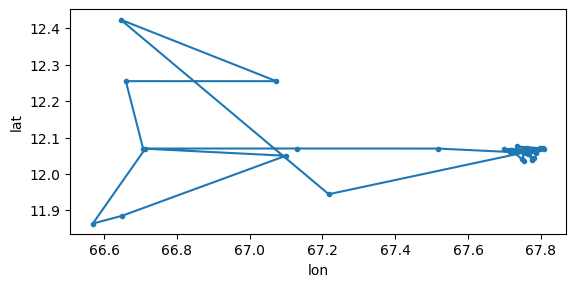

In [14]:
# plot sounding launch locations

clf()
plot(lon,lat, marker=".")
xlabel("lon"); ylabel("lat")
ax = gca()
ax.set_aspect("equal", "box")
# gcf()

In [15]:
(dtime.-DateTime(2023,5,31,0,0,0))
Dates.value.(dtime)/86400000
Dates.value.(dtime.-DateTime(2023,5,31,0,0,0))./86400000
day.(dtime)

36-element Vector{Int64}:
 17
 17
 17
 17
 18
 18
 19
 19
 19
 19
 20
 20
 20
  ⋮
 22
 22
 22
 22
 23
 23
 23
 23
 23
 23
 24
 24

In [16]:
"kmean vertical index hack useful to kludge a vertical coordinate"
function kmean(x)
    mask = isfinite.(x)
    a = zeros(size(x,1))
    for ki = 1:size(x,1)
        a[ki] = sum(filter(isfinite,x[ki,:])) ./ sum(mask[ki,:]) # mean along 2d dimension
    end
    a
end
# exploits that data are already gridded in 10-m z bins.
# !but the bins are offset for each sounding!
# this is not really the right way of averaging, but it shows we have timeheight data
# better: interpolate all to consistent 1-hPa pressure grid
# see grid_imd_soundings.

kmean(pres)

pres

3000×36 Matrix{Float64}:
 1008.4  1010.5  1007.7  1010.9  1009.3  …  1009.3  1007.7  1007.0  1008.5
 1007.3  1009.4  1006.6  1009.8  1008.1     1008.1  1006.5  1005.8  1007.4
 1006.2  1008.3  1005.5  1008.7  1007.0     1007.0  1005.4  1004.7  1006.3
 1005.0  1007.1  1004.3  1007.5  1005.8     1005.8  1004.2  1003.5  1005.2
 1003.9  1006.0  1003.2  1006.4  1004.7     1004.7  1003.1  1002.4  1004.0
 1002.8  1004.9  1002.1  1005.3  1003.6  …  1003.5  1002.0  1001.3  1002.9
 1001.6  1003.8  1001.0  1004.2  1002.5     1002.4  1000.8  1000.2  1001.8
 1000.5  1002.7   999.8  1003.0  1001.3     1001.3   999.7   999.0  1000.7
  999.4  1001.5   998.7  1001.9  1000.2     1000.1   998.6   997.9   999.5
  998.3  1000.4   997.6  1000.8   999.1      999.0   997.5   996.8   998.4
  997.2   999.3   996.5   999.7   998.0  …   997.9   996.4   995.7   997.3
  996.0   998.2   995.4   998.6   996.9      996.8   995.2   994.6   996.2
  994.9   997.1   994.3   997.4   995.7      995.6   994.1   993.5   995.1


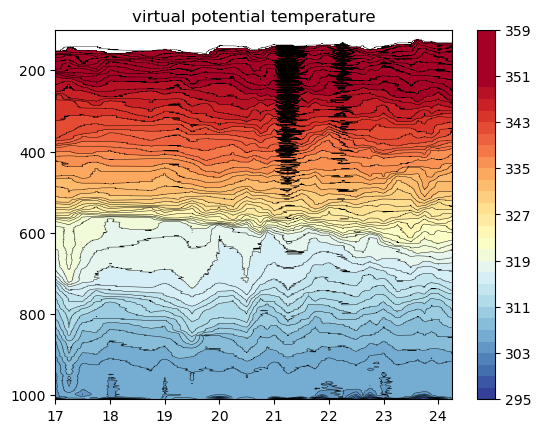

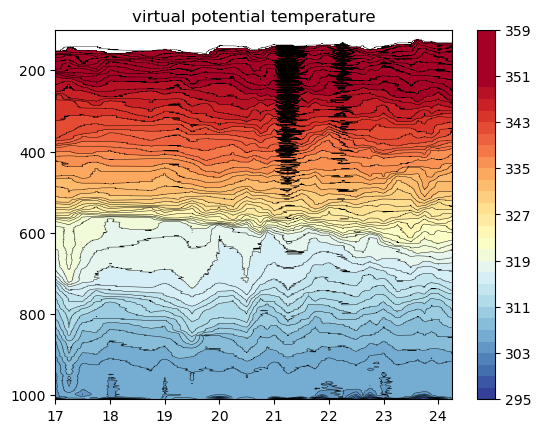

In [17]:
pd = permutedims

qv = @. rh/100 * qs(pres*100.0, temp)
let
   clf()
   # contourf(raobe_dt(files), )
   # contourf(temp./Exner.(pres))
   junedate = Dates.value.(dtime.-DateTime(2023,5,31,0,0,0))./86400000
   # subplot(2,1,1)
   contourf(junedate, kmean(pres[1:2400,:]), (1.0 .+0.608.*qv[1:2400,:]).*(temp[1:2400,:].+C)./Exner.(pres[1:2400,:]),
      vmax=350.0, levels=295:2:360, cmap=ColorMap("RdYlBu_r"))
   colorbar()
   contour(junedate, kmean(pres[1:2400,:]), (1.0 .+0.608.*qv[1:2400,:]).*(temp[1:2400,:].+C)./Exner.(pres[1:2400,:]),
      vmax=350.0, levels=295:1:360, colors="k", linewidths=0.3)
   title("virtual potential temperature")
   ylim([1010, 100])
   gcf()
end

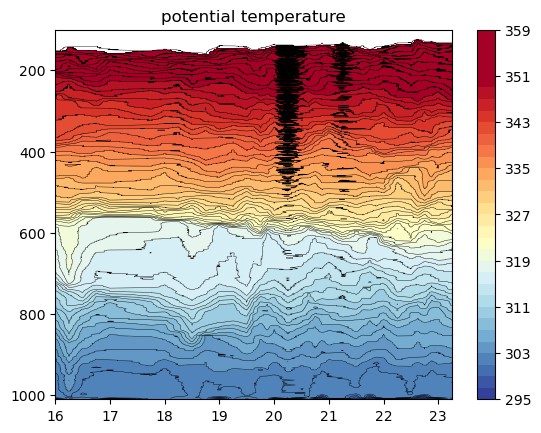

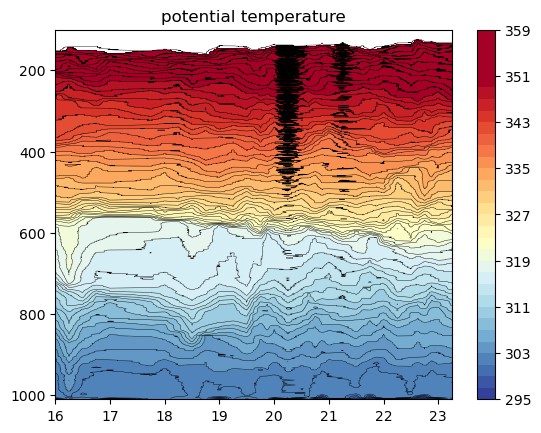

In [18]:

let
   clf()
   junedate = Dates.value.(dtime.-DateTime(2023,6,1,0,0,0))./86400000
   contourf(junedate, kmean(pres[1:2200,:]), (temp[1:2200,:].+C)./Exner.(pres[1:2200,:]),
      vmax=350.0, levels=295:2:360, cmap=ColorMap("RdYlBu_r"))
   colorbar()
   contour(junedate, kmean(pres[1:2200,:]), (temp[1:2200,:].+C)./Exner.(pres[1:2200,:]),
      vmax=350.0, levels=295:1:360, colors="k", linewidths=0.3)
   title("potential temperature")
   ylim([1010, 100])
   gcf()
end

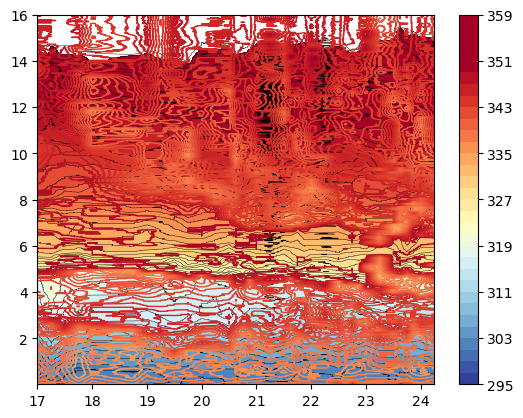

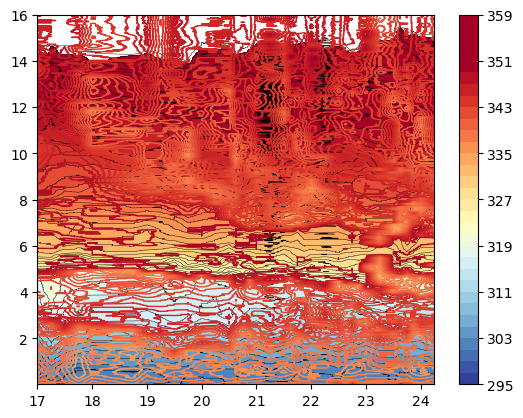

In [19]:
clf()
# contourf(raobe_dt(files), )
# contourf(temp./Exner.(pres))
junedate = Dates.value.(dtime.-DateTime(2023,5,31,0,0,0))./86400000
# subplot(2,1,1)
contourf(junedate, kmean(gpm[1:2200,:])./1e3, (temp[1:2200,:].+C)./Exner.(pres[1:2200,:]),
   vmax=350.0, levels=295:2:360, cmap=ColorMap("RdYlBu_r"))
colorbar()
contour(junedate, kmean(gpm[1:2200,:])./1e3, (temp[1:2200,:].+C)./Exner.(pres[1:2200,:]),
   vmax=350.0, levels=295:1:360, colors="k", linewidths=0.3)
contour(junedate, kmean(gpm[1:2200,:])./1e3, rh[1:2200,:],
   vmax=350.0, levels=0:5:100, cmap=ColorMap("RdYlBu"), linewidths=1)

ylim([0.015, 16.0])
gcf()

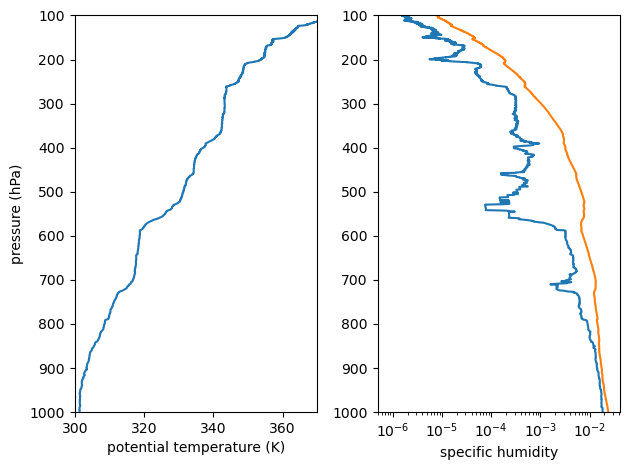

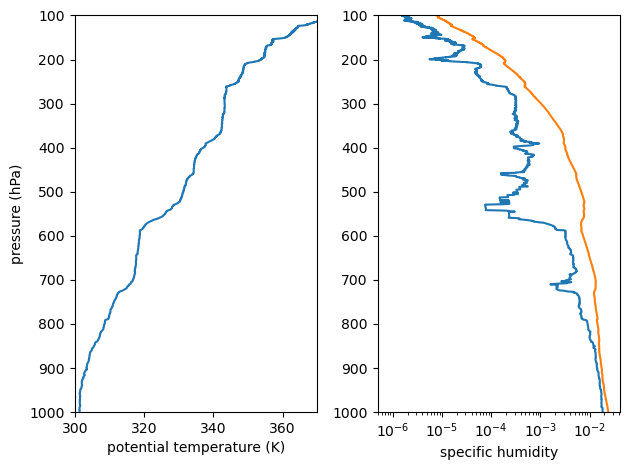

In [20]:
# plot example sounding
let
    qs_ = @. qs(1e2*df[!,:PRES], df[!,:TEMP])
    qv = @. qs_ * df[!,:RH]/1e2
    theta_ = @. (df[!,:TEMP]+C) / Exner(df[!,:PRES])

    clf()
    subplot(1,2,1)
    plot(theta_, df[!,:PRES])
    ylabel("pressure (hPa)")
    xlabel("potential temperature (K)")
    ylim([1000, 100])
    xlim([300, 370])

    subplot(1,2,2)
    # plot(df[!,:RH], df[!,:PRES])
    semilogx(qv, df[!,:PRES])
    plot(qs_, df[!,:PRES])
    ylim([1000, 100])
    xlabel("specific humidity")
    tight_layout()
    gcf()
end

In [21]:
# functions to process sounding variables 

function zonalwind( speed, wind )
    -speed * sind(wind)
end
function meridionalwind( speed, wind )
    -speed * cosd(wind)
end

# function uv( df::DataFrame )
#     u = -df[!,:SPEED] * sind(df[!,:WIND])
#     v = -df[!,:SPEED] * cosd(df[!,:WIND])
#     return u,v
# end

function pottmp( temp, pres )
    (temp+C) / Exner(pres)
end
function pottmp( df::DataFrame )
    (df[!,:TEMP]+C) / Exner(df[!,:PRES])
end

function spechum( rh, temp, pres )
    rh/1e2 * qs(pres*1e2, temp)
end

spechum (generic function with 1 method)

In [22]:
# Interpolation methods
# Pressure is irregular and different for each sounding time.

"dv converts Datetimes to numeric values for Interpolations."
dv(dt, offset=DateTime(2019,3,1)) = Dates.value(dt - offset)

# interpolation functions
function itp_sparse(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end

"Returns function that filters missing data from the input sounding before interpolating."
function itp(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind] .+ x[ind]) # .& .!ismissing.(p[ind] .+ x[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end

"rectangular interval averaging onto a decreasing pressure coordinate"
function pavg(x::Vector, p::Vector; plevs=1020.0:-5.0:0.0)
    s1 = zeros(Float64, size(plevs))
    # s2 = zeros(Float64, size(p))
    ns = zeros(Float64, size(plevs))
    
    for i in eachindex(p)
        j = findfirst(x -> x < p[i], plevs) # j indexes plevs
        if !isnothing(j)
            s1[j] += isfinite(x[i]) ? x[i] : 0
            # s2[j] += x[i]^2
            ns[j] += 1.0*isfinite(x[i])
        end
    end
    
    s1 ./ ns # mean
end

# pressure levels to interploate to
dp = 5.0
plevs = 1020.0:-dp:0.0
length(plevs)

205

## soundings for LES

In [23]:
# plot 2 cases for Eric's LES modeling

u =      zonalwind.( speed, wind )
v = meridionalwind.( speed, wind )
th = pottmp.( temp, pres ) # full resolution

ind = findall(dt-> DateTime(2023,6,16,23,0,0)<dt<DateTime(2023,6,18,1,0,0), dtime)

5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [24]:
# collect interesting levels (Jun 17)
Xth = ([302,  304,  317,  318,  330,  340,   345,   358,   370,   390,   450 ],
       [0  , 1000, 3000, 5000, 5800, 8000, 10500, 14000, 16000, 17500, 19500 ])
Xrh = ([80,   75,   20,   45,   50,    5,    5,   15,    25,    25,    25,    25,     2 ],
       [0 , 2000, 3000, 4000, 4800, 5000, 5800, 8000, 10500, 14000, 16000, 17500, 19500 ])
Xu = ([8,   12,    8,    0,  -8,     0,    5,    4,   -1,   -10,   -30,   -45,   -30,   -10 ],
      [0, 1200, 2000, 3000, 4800, 5000, 5800, 7200, 8000, 10500, 14000, 16000, 17500, 19500 ])
Xv = ([6,   4,    2,    -1,  -2,     0,    3,     0,   -1,   -10,    0,     0,    -3,     0,    -3 ],
      [0, 1200, 2000, 3000, 4800, 5000, 5800, 7200, 8000, 10500, 12000, 14000, 16500, 17500, 19500 ])

# unified interesting levels
zed = sort(union(40, 5200, 6800, 9000, Xth[2], Xrh[2], Xu[2], Xv[2]))

22-element Vector{Int64}:
     0
    40
  1000
  1200
  2000
  3000
  4000
  4800
  5000
  5200
  5800
  6800
  7200
  8000
  9000
 10500
 12000
 14000
 16000
 16500
 17500
 19500

In [25]:
# median soundings on z coordinate

"replace NaN with missing."
n2m(x) = replace(x, NaN => missing)
"replace missing with NaN"
m2n(x) = replace(x, missing => NaN)

# medians of each variable
Md = Dict()

# proto th
x = [ itp(th[:,i], gpm[:,i])[zed] for i in ind ]
x = mapreduce(permutedims, vcat, n2m.(x))

# x = n2m(x)
"missmedian gracefully skips missing, and returns missing when all inputs are missing."
function missmedian_(x) 
    y = skipmissing(x)
    if isempty( y )
        return missing
    else
        return median( y )
    end
end

"reduce along dimesion dim missmedian(x; dim)"
function missmedian(x; dim)
    sx = size(x)
    y = Array{Union{Missing, eltype(x)}}(missing, sx[[1:(dim-1); (dim+1):end]])
    Rpre = CartesianIndices(sx[1:dim-1])
    Rpost = CartesianIndices(sx[dim+1:end])
    for Ipost in Rpost    # iterate over, don't operate on, these dimensions
        for Ipre in Rpre
            y[Ipre, Ipost] = missmedian_( x[Ipre,:,Ipost] )
        end
    end
    return y
end

"interpolate and take median among ind of sounding variable x[ind,k]"
function zedit(x, ind=ind, zed=zed)
    missmedian( mapreduce(permutedims, vcat, n2m.(
        [ itp(x[:,i], gpm[:,i])[zed] for i in ind ] )), dim=1 )
end

zedit(th)

22-element Vector{Union{Missing, Float64}}:
    missing
 302.099066833728
 303.5957786835604
 304.4966220145762
 308.4530940804931
 316.03145377289076
 318.2423333367614
 319.36954573003914
 321.42121797313797
 325.55961340407447
 330.9450713007997
 334.4034437959848
 335.0725018173859
 338.6428185422026
 342.41738238061845
 345.6792727131275
 349.8986955071813
 357.94779032160864
 370.00951579693185
 374.37182983268946
 385.2194277316912
 451.636374350589

In [26]:
#=
# 2023 Jun 17 dataframe sounding for Eric

Z = [ zed, m2n(zedit(th)), m2n(zedit(rh)), m2n(zedit(u)), m2n(zedit(v)), m2n(zedit(temp)), m2n(zedit(pres))]
dfzed = DataFrame(Z, [:gpm, :pot_temp, :rh, :u, :v, :temp, :pres])
CSV.write("ekamsatPilotSounding20230617.csv", dfzed)

# 2023 June 21,22 dataframe sounding for Eric
for jundate in [17,21,22]
    ind = findall(dt-> DateTime(2023,6,jundate-1,23,0,0)<dt<DateTime(2023,6,jundate+1,1,0,0), dtime)
    Z = [ zed, m2n(zedit(th,   ind)), 
               m2n(zedit(rh,   ind)), 
               m2n(zedit(u,    ind)),
               m2n(zedit(v,    ind)),
               m2n(zedit(temp, ind)), 
               m2n(zedit(pres, ind)) ]
    dfzed = DataFrame(Z, [:gpm, :pot_temp, :rh, :u, :v, :temp, :pres])
    CSV.write("ekamsatPilotSounding202306$(jundate).csv", dfzed)
end
=#

## plot soundings

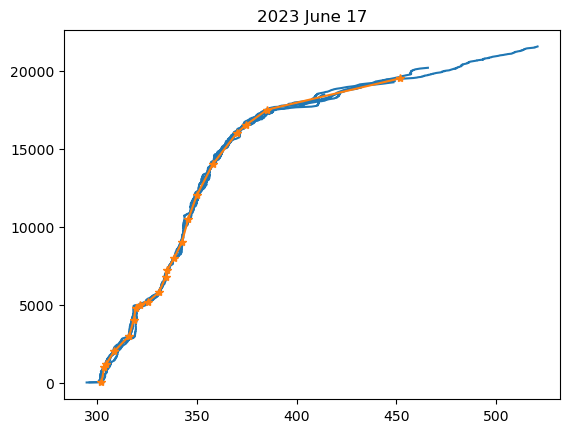

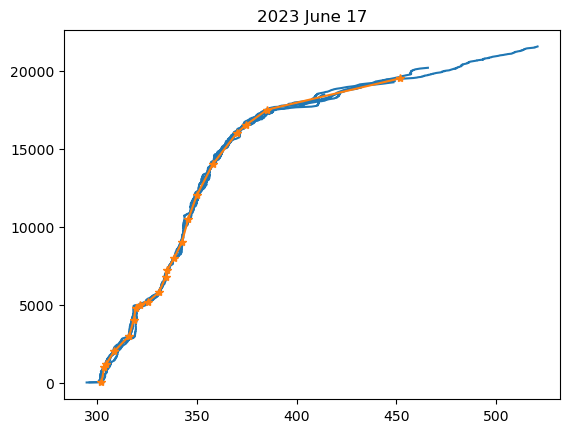

In [27]:
jundate = 17 # [17,21,22]

ind = findall(dt-> DateTime(2023,6,jundate-1,23,0,0)<dt<DateTime(2023,6,jundate+1,1,0,0), dtime)

clf()
plot(th[:,ind], gpm[:,ind], label=L"\theta", color="tab:blue")
# plot([302,  304,  317,  318,  330,  340,   345,   358,   370,   390,   450 ],
#      [0  , 1000, 3000, 5000, 5800, 8000, 10500, 14000, 16000, 17500, 19500 ], marker="o", color="k")
plot(m2n(zedit(th,ind)), zed, color="tab:orange", marker="*")
title("2023 June $(jundate)")
gcf()

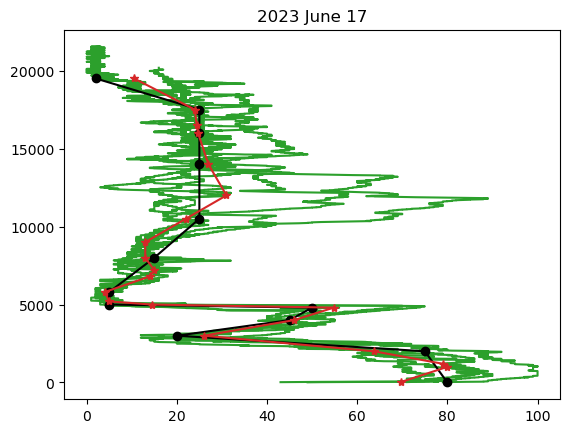

PyObject Text(0.5, 1.0, '2023 June 17')

In [28]:
ind = findall(dt-> DateTime(2023,6,jundate-1,23,0,0)<dt<DateTime(2023,6,jundate+1,1,0,0), dtime)

clf()
plot(rh[:,ind], gpm[:,ind], label="rh", color="tab:green")
plot([80,   75,   20,   45,   50,    5,    5,   15,    25,    25,    25,    25,     2 ],
     [0 , 2000, 3000, 4000, 4800, 5000, 5800, 8000, 10500, 14000, 16000, 17500, 19500 ], marker="o", color="k")
plot(m2n(zedit(rh)), zed, color="tab:red", marker="*")
title("2023 June $(jundate)")
# gcf()

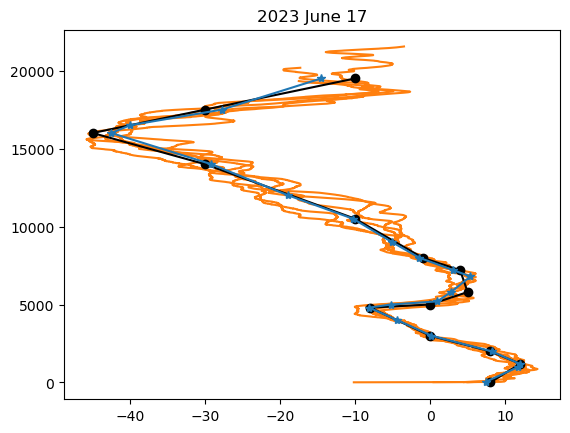

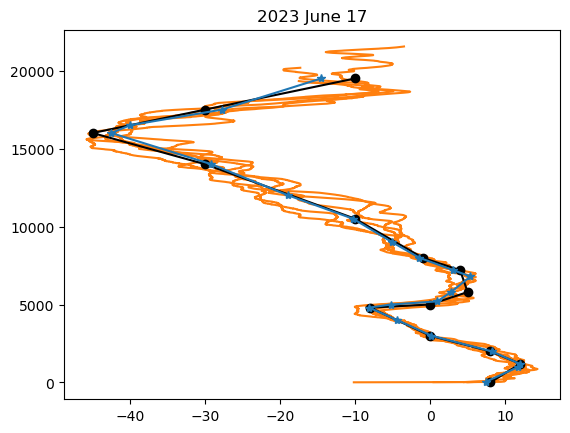

In [29]:
ind = findall(dt-> DateTime(2023,6,jundate-1,23,0,0)<dt<DateTime(2023,6,jundate+1,1,0,0), dtime)

clf()
plot(u[:,ind], gpm[:,ind], label=L"u", color="tab:orange")
plot([8,   12,    8,    0,  -8,     0,    5,    4,   -1,   -10,   -30,   -45,   -30,   -10 ],
     [0, 1200, 2000, 3000, 4800, 5000, 5800, 7200, 8000, 10500, 14000, 16000, 17500, 19500 ], marker="o", color="k")
plot(m2n(zedit(u)), zed, color="tab:blue", marker="*")
title("2023 June $(jundate)")
gcf()

In [7]:
ind = findall(dt-> DateTime(2023,6,jundate-1,23,0,0)<dt<DateTime(2023,6,jundate+1,1,0,0), dtime)

clf()
plot(v[:,ind], gpm[:,ind], label="v", color="tab:red")
title("2023 June $(jundate)")
plot([6,   4,    2,    -1,  -2,     0,    3,     0,   -1,   -10,    0,     0,    -3,     0,    -3 ],
     [0, 1200, 2000, 3000, 4800, 5000, 5800, 7200, 8000, 10500, 12000, 14000, 16500, 17500, 19500 ], marker="o", color="k")
plot(m2n(zedit(v)), zed, color="tab:blue", marker="*")
gcf()

LoadError: UndefVarError: `dtime` not defined

In [39]:
# sounding variable functions

meanfinite(x, dims) = sum(isfinite(x) ? x : 0, dims=dims)./sum(isfinite, x, dims=dims)
anom(x; dims=ndims(x)) = x .- meanfinite(x, dims)

# put NaNs in for missing for matplotlib
m2n(x) = ismissing(x) ? NaN : x

m2n (generic function with 1 method)

In [40]:
# do a big loop to reload and interpolate data to consistent levels

"load, interpolate, and concatenate many soundings"
function cat_int_raobe( files, datapath=datapath; plevs=plevs )
    nt = length( files )
    nz = length( plevs )

    dtime = raobe_dt.(files)
    lat = zeros(nt)
    lon = zeros(nt)

    # initialize variables to be interpolated as NaN arrays
    pres = NaN.+zeros(nz,nt)
    temp = NaN.+zeros(nz,nt)
    rh = NaN.+zeros(nz,nt)
    gpm = NaN.+zeros(nz,nt)
    shum =  NaN.+zeros(nz,nt)
    u = NaN.+zeros(nz,nt)
    v = NaN.+zeros(nz,nt)

    i = 0
    for f in files
        i += 1
        # dtime[i] = raobe_dt(f)
        df, lat[i], lon[i] = read_raobe(joinpath(datapath, f))
        p = df[!,:PRES] # Vector of exact length of input data
        # pres[:,i]  .= p
        temp[:,i]  .= pavg( df[!,:TEMP],  p, plevs=plevs )
        rh[:,i]    .= pavg( df[!,:RH],    p, plevs=plevs )
        gpm[:,i]   .= pavg( df[!,:GPM],   p, plevs=plevs )
        shum[:,i]  .= pavg( df[!,:RH]./1e2 .* qs.(p*1e2, df[!,:TEMP]), p, plevs=plevs)
        u[:,i] .= pavg( -df[!,:SPEED] .* sind.(df[!,:WIND]), p, plevs=plevs )
        v[:,i] .= pavg( -df[!,:SPEED] .* cosd.(df[!,:WIND]), p, plevs=plevs )
    end
    lat,lon,dtime, temp,rh,shum,u,v,gpm
end

# do it; overwrites global raw sounding variables
lat,lon,dtime, temp,rh,shum,u,v,gpm = cat_int_raobe( raobe_files )

([12.057000160217285, 12.069860458374023, 12.069999694824219, 12.069860458374023, 11.863920211791992, 11.885000228881836, 12.050060272216797, 12.069780349731445, 12.255029678344727, 12.254940032958984  …  12.070329666137695, 12.075639724731445, 12.070420265197754, 12.03756046295166, 12.065469741821289, 12.059809684753418, 12.056110382080078, 12.069939613342285, 12.06350040435791, 12.044440269470215], [67.78558349609375, 67.51805877685547, 67.13111114501953, 66.71357727050781, 66.56913757324219, 66.64897155761719, 67.09928131103516, 66.70732879638672, 66.6598129272461, 67.07341766357422  …  67.80458068847656, 67.73493957519531, 67.76207733154297, 67.77446746826172, 67.7712173461914, 67.71630859375, 67.76569366455078, 67.80774688720703, 67.739501953125, 67.78005981445312], [DateTime("2023-06-17T00:00:00"), DateTime("2023-06-17T06:00:00"), DateTime("2023-06-17T12:00:00"), DateTime("2023-06-17T18:00:00"), DateTime("2023-06-18T00:00:00"), DateTime("2023-06-18T18:00:00"), DateTime("2023-06-1

## overview plots

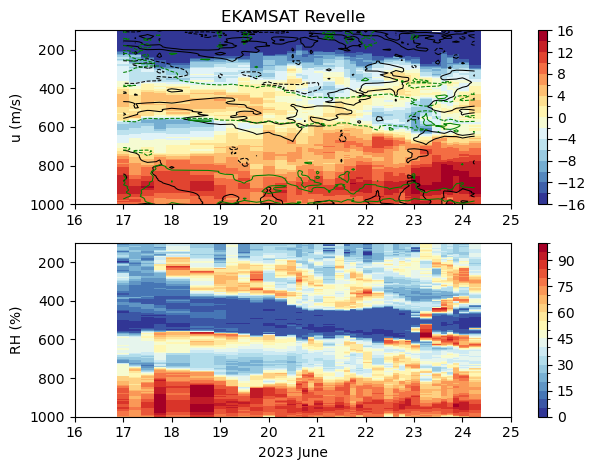

"../plot/Revelle_u_rh.svg"

In [83]:
# time-height plot from Revelle pilot

"output days from offset"
mpldate(timestamp, offset=DateTime(2023,5,31,0,0,0)) = Dates.value(timestamp-offset)/1000/60/60/24
#invmpldate( mlpd, offset=DateTime(2023,4,30,0,0,0) ) = mpldate+Dates.value(offset)/1000/60/60/24
mplday(d; offset=Date(2023,5,31)) = day(Day(d) + offset) # ticks
# TIME offset CHANGED


clf()
subplot(2,1,1)
norm = PyPlot.matplotlib.colors.BoundaryNorm(boundaries=-16:2:16, ncolors=256)
pcolormesh( mpldate.(dtime), plevs, u, norm=norm, cmap=ColorMap("RdYlBu_r") )
colorbar()
contour( mpldate.(dtime), plevs, v, levels=2:5:15, vmin=1, vmax=10, colors="k", linewidths=0.75)
contour( mpldate.(dtime), plevs, v, levels=-15:5:-2, vmin=-10, vmax=-1, linestyles="--", colors="k", linewidths=0.75)
contour( mpldate.(dtime), plevs, rh, levels=[20], colors="g", linewidths=0.75, linestyles="--")
contour( mpldate.(dtime), plevs, rh, levels=[80], colors="g", linewidths=0.75, linestyles="-")
ylim(1000, 100)
ylabel("u (m/s)")
xtl,~ = xticks()
xticks( xtl, mplday.(xtl, offset=Date(2023,5,31)) )
title("EKAMSAT Revelle")

subplot(2,1,2)
norm = PyPlot.matplotlib.colors.BoundaryNorm(boundaries=0:5:100, ncolors=256)
pcolormesh( mpldate.(dtime), plevs, rh, norm=norm, cmap=ColorMap("RdYlBu_r"))
ylim(1000, 100)
ylabel("RH (%)")
xtl,~ = xticks()
xticks( xtl, mplday.(xtl, offset=Date(2023,5,31)) )
colorbar()
xlabel(Dates.format(dtime[1], "yyyy U"))

tight_layout()

figfile = "../plot/Revelle_u_rh.svg"
# savefig( figfile )
# gcf()

clockwise rotation of wind anomalies at 400 hPa